In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

### Plot single agent

In [2]:
def agent_marker(angle):
    a = np.array([[-1.0,-1.0],
                  [-0.5, 0.0],
                  [-1.0, 1.0],
                  [ 1.0, 0.0]])
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    return R.dot(a.T).T    

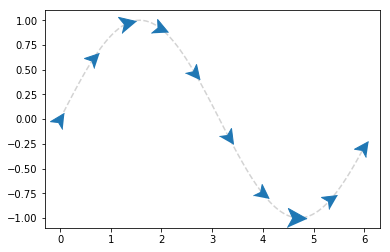

In [3]:
plt.figure()

tt = np.linspace(0, 6, 100)
plt.plot(tt, np.sin(tt), color='lightgrey', linestyle='--')

t = np.linspace(0, 6, 10)
for (x, y, psi) in zip(t, np.sin(t), np.cos(t)):
    plt.plot([x], [y], marker=agent_marker(psi), markersize=20, color='C0')

(-10, 10)

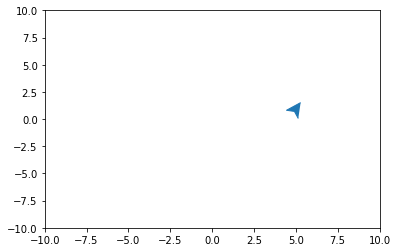

In [4]:
# Update agent position
[l] = plt.plot([x], [y], marker=agent_marker(psi), markersize=20, color='C0')
l.set_data([5.0, 1.0])
plt.xlim([-10, 10])
plt.ylim([-10, 10])

### Agent class

In [5]:
class Agent():
    def __init__(self, x=0.0, y=0.0, vx=0.0, vy=0.0, psi=0.0):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.psi = psi
        
    def update(self, ax=0.0, ay=0.0, vpsi=0.0, dt=0.1):
        self.vx += ax * dt
        self.vy += ay * dt
        self.x += self.vx * dt
        self.y += self.vy * dt
        self.psi += vpsi * dt   

In [6]:
def plot_agent(ax, agent, **args):
    ax.plot([agent.x], [agent.y], marker=agent_marker(agent.psi), **args)

### Example with N agents

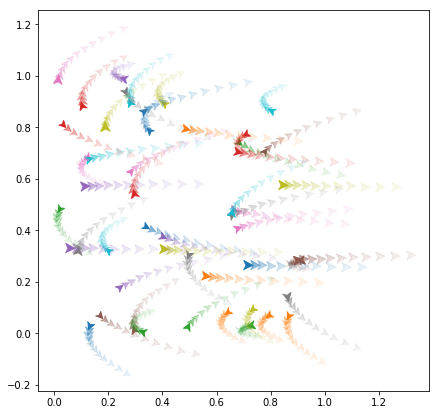

In [7]:
# Init N agents
n_agents = 50
agents = [Agent(x=_x, y=_y, vx=0.1 * np.cos(_psi), vy=0.1 * np.sin(_psi), psi=_psi)
          for (_x, _y, _psi) in zip(np.random.rand(n_agents), 
                                    np.random.rand(n_agents),
                                    2.0*np.pi*np.random.rand(n_agents))]

# Plot init state
fig, axis = plt.subplots(figsize=[7, 7])
for agent in agents:
    plot_agent(axis, agent, markersize=10, alpha=1.0)
        
# Update agents state
for i in range(10):
    for agent in agents:
        # update with fixed accel
        agent.update(dt=0.2, ax=0.1)
        
        # coordinated turn
        agent.psi = np.arctan2(agent.vy, agent.vx)
        
        # plot state
        plot_agent(axis, agent, markersize=10, alpha=1.0 / (2 + i))

### Reynolds class

In [17]:
class Reynolds:
    def __init__(self, 
                 k_cohesion=1.0, k_separation=1.0, k_alignment=1.0,
                 dist_max=0.5, n_max=5):
        self.k_cohesion = k_cohesion 
        self.k_separation = k_separation 
        self.k_alignment = k_alignment
        self.dist_max = dist_max
        self.n_max = n_max
        
    def compute_one(self, index, agents):
        a = agents[index]
        others = np.hstack([np.array(agents)[:index],
                            np.array(agents)[index+1:]])
                
        # Compute distance to other agents
        distances = np.array([np.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)
                             for b in others])
                
        # Remove agents that are too far
        sel_index = distances < self.dist_max
        others = others[sel_index]
        distances = distances[sel_index]
        
        # Keep max n_max agents
        sel_index = distances.argsort()[:self.n_max]
        others = others[sel_index]
        distances = distances[sel_index]
        
        n_neighbors = len(distances)
        if n_neighbors > 0:
            # Compute cohesion accel
            pos_a = np.array([a.x, a.y])
            pos_others = np.array([[b.x, b.y]
                                   for b in others])
            cohesion = self.k_cohesion * (pos_others - pos_a).mean(axis=0)

            # Compute separation accel
            pos_rel = pos_others - pos_a
            pos_rel_u = pos_rel / np.linalg.norm(pos_rel, axis=1)[:,np.newaxis]
            separation = - self.k_separation * (pos_rel_u / distances[:, np.newaxis]).mean(axis=0)

            # Compute alignment vpsi
            vel_a = np.array([a.vx, a.vy])
            vel_others = np.array([[b.vx, b.vy]
                                   for b in others])
            alignment = self.k_alignment * (vel_others - vel_a).mean(axis=0)
        else:
            cohesion = np.array([0.0, 0.0])
            separation = np.array([0.0, 0.0])
            alignment = np.array([0.0, 0.0])
            
        return cohesion, separation, alignment
    
    def update_one(self, index, agents):
        cohesion, separation, alignment = self.compute_one(index, agents)
        accel = cohesion + separation + alignment 
        return accel
    
    def update(self, agents):
        for i in range(len(agents)):
            self.update_one(i, agents)

In [18]:
reynolds = Reynolds(n_max=5)
reynolds.update_one(3, agents)
reynolds.update(agents)

### Example with N agents

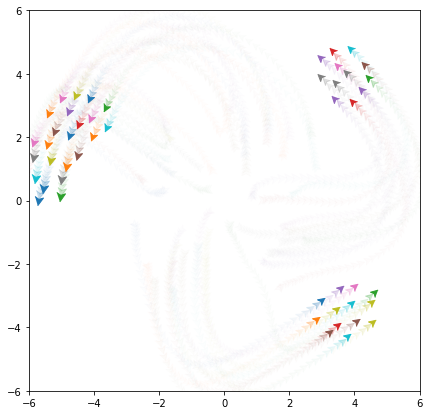

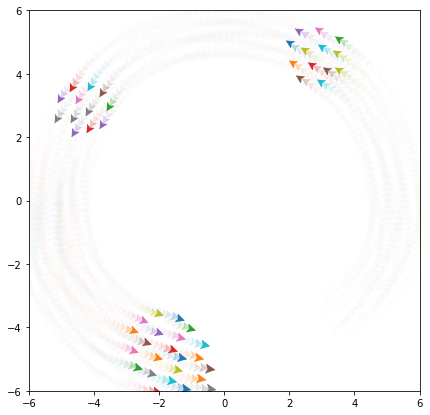

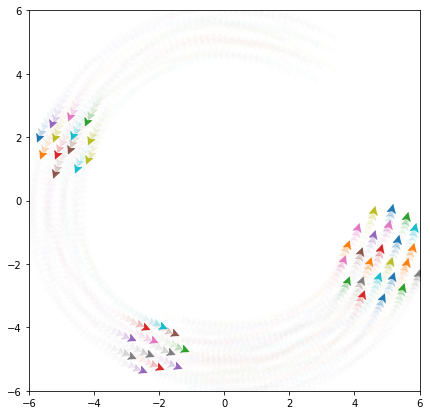

In [48]:
# Init N agents
n_agents = 50
agents = [Agent(x=_x, y=_y, vx=0.1 * np.cos(_psi), vy=0.1 * np.sin(_psi), psi=_psi)
          for (_x, _y, _psi) in zip(6.0*(np.random.rand(n_agents) - 0.5), 
                                    6.0*(np.random.rand(n_agents) - 0.5),
                                    2.0*np.pi*np.random.rand(n_agents))]
# Init Reynolds
reynolds = Reynolds(dist_max=2.0, n_max=10,
                    k_separation=1.0,
                    k_cohesion=1.0,
                    k_alignment=1.0)

t = 0.0
dt = 0.1


n_run = 3
for run in range(n_run):
    # Prepare figure
    fig, axis = plt.subplots(figsize=[7, 7])
    axis.set_xlim([-6, 6])
    axis.set_ylim([-6, 6])

    # Plot init state
#     for agent in agents:
#         plot_agent(axis, agent, markersize=10, alpha=1.0)

    # Update agents state
    n_steps = 50
    for k in range(n_steps):
        
        # Increment time
        t = t + dt
        
        # Update migration point that moves at constant velocity on a circle
        pos_wpt = np.array([0, 0])
        rad_wpt = 5.0
        vel_wpt = 1.0
        pos_mig = pos_wpt + rad_wpt * np.array([np.cos(2 * np.pi * t * vel_wpt / (2 * np.pi * rad_wpt)), 
                                                np.sin(2 * np.pi * t * vel_wpt / (2 * np.pi * rad_wpt))])
        
        for i, agent in enumerate(agents):
            # Reynolds rules
            accel = reynolds.update_one(i, agents)
        
            # Add migration rule as fixed-speed velocity command towards the moving waypoint
            pos_a = np.array([agent.x, agent.y])
            pos_tan = rad_wpt * (pos_a - pos_wpt) / np.linalg.norm(pos_a - pos_wpt)
            
            vel_agent = 1.0
            vel_tan = np.array([-pos_tan[1], pos_tan[0]])
            vel_tan = vel_agent * vel_tan / np.linalg.norm(vel_tan)
            
            pos_mig = pos_wpt + pos_tan + 1.0 * vel_tan
            pos_rel = pos_mig - pos_a
            
            vel_des = 1.0 * pos_rel
            vel_a = np.array([agent.vx, agent.vy])
            migration = 1.0 * (vel_des - vel_a)
            accel += migration
            
            # Update agent state
            agent.update(ax=accel[0], ay=accel[1], dt=dt)
        
            # coordinated turn
            agent.psi = np.arctan2(agent.vy, agent.vx)

            # plot state
            plot_agent(axis, agent, markersize=10, alpha= max(0.01, 1.0 / (n_steps - k)**2))

    # Plot final state
#     for agent in agents:
#         plot_agent(axis, agent, markersize=10, alpha=1.0)



In [36]:
np.sin(np.pi/2)

1.0

In [37]:
np.cos(np.pi/2)

6.123233995736766e-17